![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
import plot_functions.plot_settings

# Exercise 6 - Finite differences: soil column under gravity and top load

## Governing differential equation

Consider the equilibrium conditions on an infinitesimal element of the soil column:

$$
    \uparrow: \quad F_z - \frac{\partial F_z}{\partial z}\text{d}z - F_z - \varrho g A \text{d}z = 0
$$

The vertical force is determined by $F_z = \sigma_{zz}A = E_\text{s} A \epsilon_{zz} = -E_\text{s} A u_{z,z}$. Therefore, the equilibrium conditions read:

$$
    0 = \left[ \frac{\partial}{\partial z} \left(E_\text{s} A \frac{\partial u_z}{\partial z}\right) - \varrho g A \right]\text{d}z
$$

Considering, that the equation has to hold for an arbitrary infinitesimal non-zero $\text{d}z$, we find the ordinary differential equation

$$
    0 = \frac{\partial}{\partial z} \left(E_\text{s} A \frac{\partial u_z}{\partial z}\right) - \varrho g A
$$

Nota bene: compare this to the differential equation for a rod ('Zugstab'): $(EAu')' + n = 0$. While the cross section of a rod can vary along its length, the cross-sectional area of a soil column is considered a constant, simplifying the equation further:

$$
    0 = \frac{\partial}{\partial z} \left(E_\text{s} \frac{\partial u_z}{\partial z}\right) - \varrho g
$$



Let's put this to test.

## Finite difference discretization

We assume $E_\text{s} = \text{const.}$ and arrive at

$$
    \frac{\partial^2 u_z}{\partial z^2} = \frac{\gamma}{E_\text{s}}
$$

In the finite difference method, we introduce a grid made up, in the one-dimensional case, of a series of points. The differentials are the evaluated by finite differences between values at these points:

$$
    \frac{\partial u_z}{\partial z} \approx \frac{\Delta u_z}{\Delta z} = \frac{u_i - u_{i-1}}{z_i - z_{i-1}} = u_i'
$$

where here, backward differences were chosen (viz. forward and central differences). We also assume a constant $\Delta z$ here.

A second derivative can likewise be approximated (now using forward differences):

$$
    \frac{\partial^2 u_z}{\partial z^2} \approx u_i'' = \frac{u_{i+1}' - u_i'}{\Delta z}
$$

Substitution of the first derivatives yields:

$$
    \frac{\partial^2 u_z}{\partial z^2} \approx u_i'' = \frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta z^2}
$$

Our differential equation has now transformed into a finite difference equation evaluated at a series of points $i$ as:

$$
u_{i+1} - 2 u_i + u_{i-1} = \Delta z^2 \frac{\gamma_i}{E_{\text{s},i}}
$$

We collect all solutions $u_i$ and $z_i$ in a vector.

In [2]:
H = 10.
number_of_points = 10
Delta_z = H/(number_of_points - 1)
z = np.linspace(0,H,number_of_points)

The right-hand side is identical in every point, unless the stiffness or the specific weight changes with depth.

In [3]:
gamma = 2600. * (1.-0.38) * 9.81 # N/m³
Es = 1.e8 #Pa
RHS = np.ones(number_of_points) * gamma/Es * Delta_z**2

The left hand side can be expressed via the finite difference matrix $A_{ij}$:

In [4]:
Central_Diag = np.diag([-2.]*number_of_points,0)
#Central_Diag

In [5]:
Upper_Diag = np.diag([1.]*(number_of_points-1),1)
Lower_Diag = np.diag([1.]*(number_of_points-1),-1)

In [6]:
A = Central_Diag + Upper_Diag + Lower_Diag

Let's give this a shot and solve it.

In [7]:
u = np.linalg.solve(A,RHS)

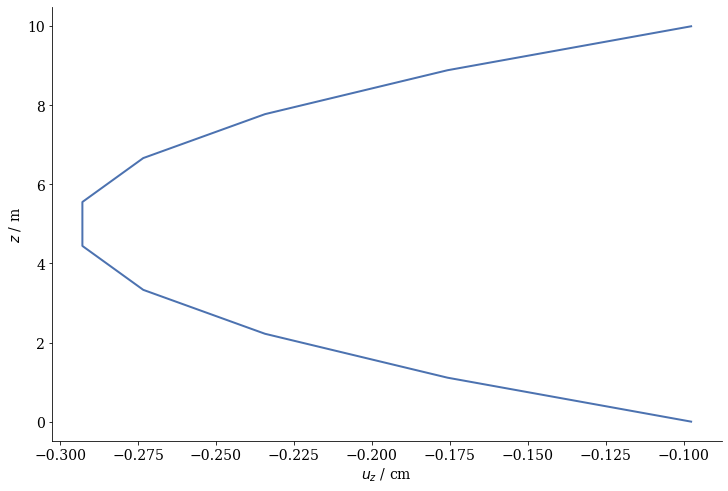

In [8]:
plt.plot(u*100,z)
plt.xlabel('$u_z$ / cm')
plt.ylabel('$z$ / m');

That doesn't look plausible. What's missing are the boundary conditions: 

$$
    u (z = 0) = 0 \qquad u'(z=H) = 0
$$

They can be integrated easily by manipulating the first and last equations (rows).

In [9]:
#lower bc
A[0,:] = 0.
A[0,0] = 1.
RHS[0] = 0.

In [10]:
#upper bc
A[-1,-1] = -1.
RHS[-1] = 0.

Let's solve the system with the boundary conditions now.

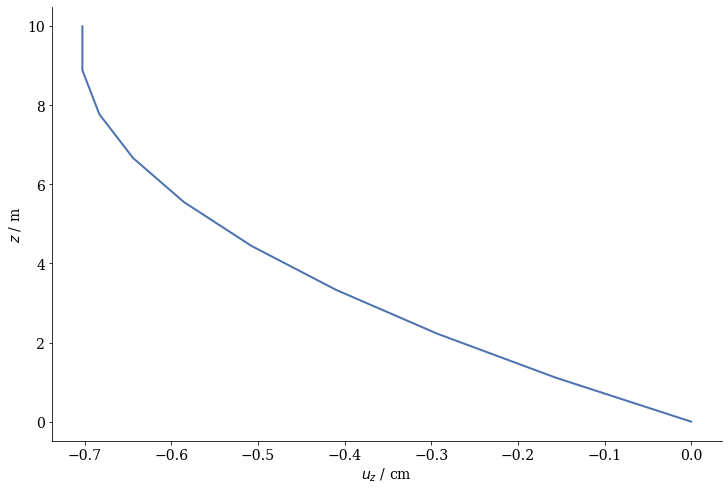

In [11]:
u = np.linalg.solve(A,RHS)
plt.plot(u*100,z)
plt.xlabel('$u_z$ / cm')
plt.ylabel('$z$ / m');

This looks plausible. Let's go ahead and perform a basic exploration of the numerical properties of the scheme.

We first define a simulation run and then vary the number of grid points.

In [12]:
def run_sim(number_of_points):
    #discretization
    Delta_z = H/(number_of_points - 1)
    z = np.linspace(0,H,number_of_points)
    #RHS
    RHS = np.ones(number_of_points) * gamma/Es * Delta_z**2
    #FD Matrix
    A = np.diag([-2.]*number_of_points,0) + np.diag([1.]*(number_of_points-1),1) + np.diag([1.]*(number_of_points-1),-1)
    #lower bc
    A[0,:] = 0.
    A[0,0] = 1.
    RHS[0] = 0
    #upper bc
    A[-1,-1] = -1.
    RHS[-1] = 0.
    #solution
    return np.linalg.solve(A,RHS), z

In [13]:
## Interactive playground

from ipywidgets import widgets
from ipywidgets import interact
#Compute reference solution with 100 cells

reference_solution, reference_z = run_sim(1000)
@interact(num_nodes=widgets.IntSlider(min=5, max=100, value=10, step=1, description='nodes'))
def plot(num_nodes=10):
    fig,ax = plt.subplots()
    ax.set_ylabel('$z$ / m')
    ax.set_xlabel('$u_z$ / cm')
    solution, z = run_sim(num_nodes)
    ax.plot(reference_solution*1e2, reference_z, '--', color='k', label='reference solution')
    ax.plot(solution*1e2,z,label='solution')
    ax.set_ylim([0,10])
    plt.show()

interactive(children=(IntSlider(value=10, description='nodes', min=5), Output()), _dom_classes=('widget-intera…

Convergence of this simple scheme is rather low. A comparatively simple finite element scheme converges much faster, as we shall see in one of the following exercises.